In [16]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings

from isca_tools.convection.base import lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.thesis.lapse_integral_simple import get_lnb_ind
from isca_tools.utils import area_weighting
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel, get_scale_factor_theory_numerical2, \
    get_scale_factor_theory, get_sensitivity_factors
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
percentile_label = 'Temperature Percentile, $x$'

In [3]:
labels_cont = {'temp_ft_change': 'FT change', 'rh_change': 'RH change', 'sCAPE_change': 'CAPE change',
               'temp_surf_anom': 'Hot-get-hotter', 'rh_anom': 'Drier-get-hotter', 'lapse_D_change': '$\eta_D$ change',
               'lapse_M_change': '$\eta_M$ change', 'lapse_D_anom': '$\eta_D$ climatological'}
leg_handlelength = 1.5

## Load data and average over `sample` dimension
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [4]:
%%time
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds, get_P
surf = 'aquaplanet'
ds = get_ds([surf], dailymax=False)[surf]
if surf == 'aquaplanet':
    ds = ds.sel(p_ft=500*100)           # had two p_ft for aquaplanet
p_ft = float(ds.p_ft)
temp_surf_lcl_calc = ds.temp_surf_lcl_calc

# Compute log pressure lapse rate quantities for each sample - then average over these
# Same for all variables, then have an averaging error at the end
# For each sample, modMSE_parc equation is satisfied, but this is not the case for the average day
ds['lapse_Dz'] = ds.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds['lapse_Mz'] = ds.modParc1_lapse.isel(layer=1) / 1000
ds['lapse_D'] = R / g * ds.TREFHT * ds['lapse_Dz']
ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']

lat_weights = np.cos(np.deg2rad(ds.lat))

CPU times: user 52.2 s, sys: 3.6 s, total: 55.8 s
Wall time: 58.3 s


In [7]:
from isca_tools.papers.miyawaki_2022 import get_lapse_dev
ds_use = ds.isel(sample=slice(0, 40))
ds_use['miy_M'], ds_use['miy_D'] = get_lapse_dev(ds_use.T, get_P(ds_use), ds_use.PS)

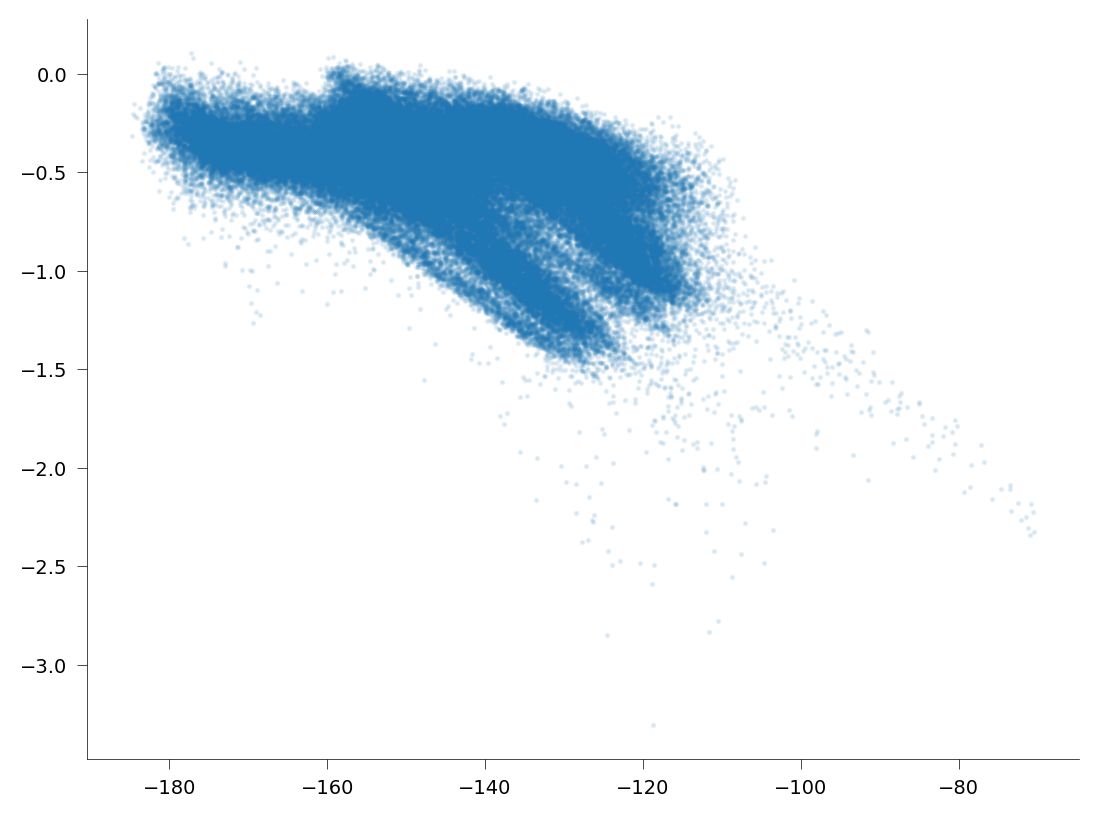

In [12]:
plt.scatter(ds_use.miy_D, ds_use.lapse_Dz*1000, s=1, alpha=0.1)

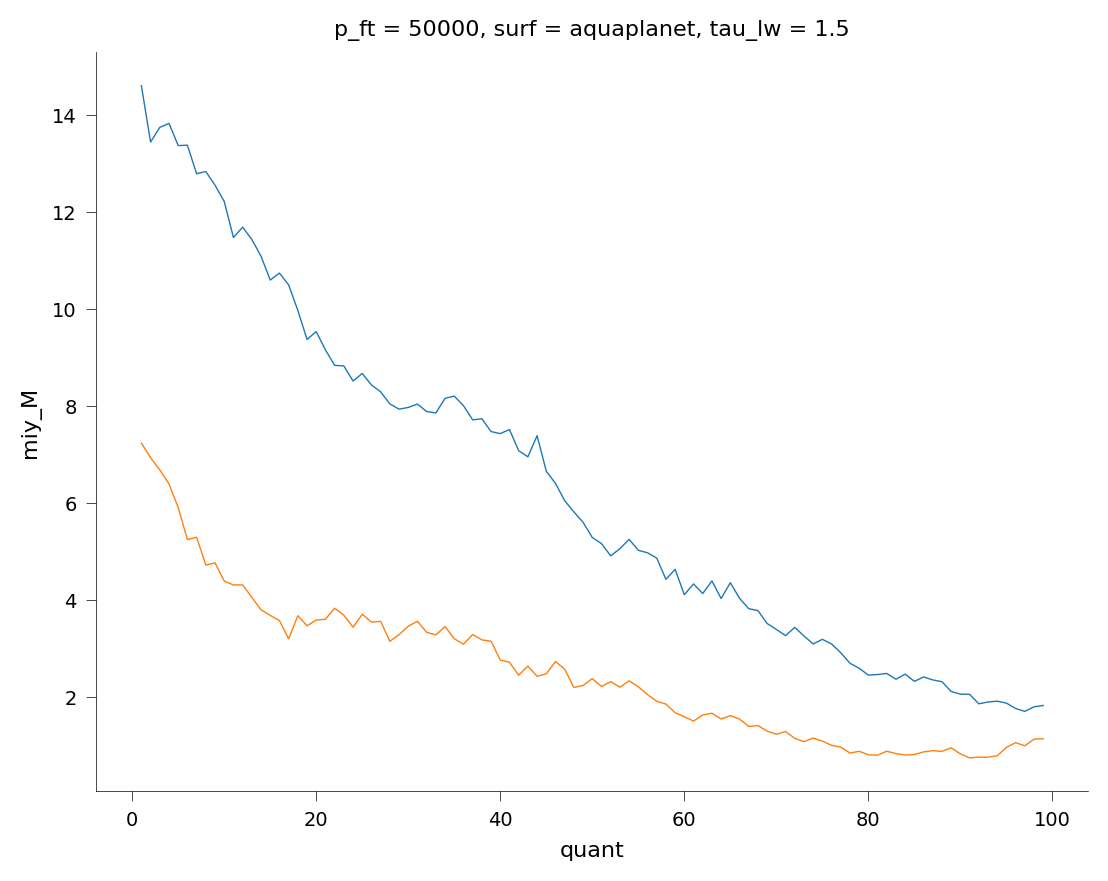

In [30]:
area_weighting(ds_use.miy_M.mean(dim='sample')).mean(dim='lat').isel(tau_lw=0).plot()
area_weighting(ds_use.miy_M.mean(dim='sample')).mean(dim='lat').isel(tau_lw=1).plot()

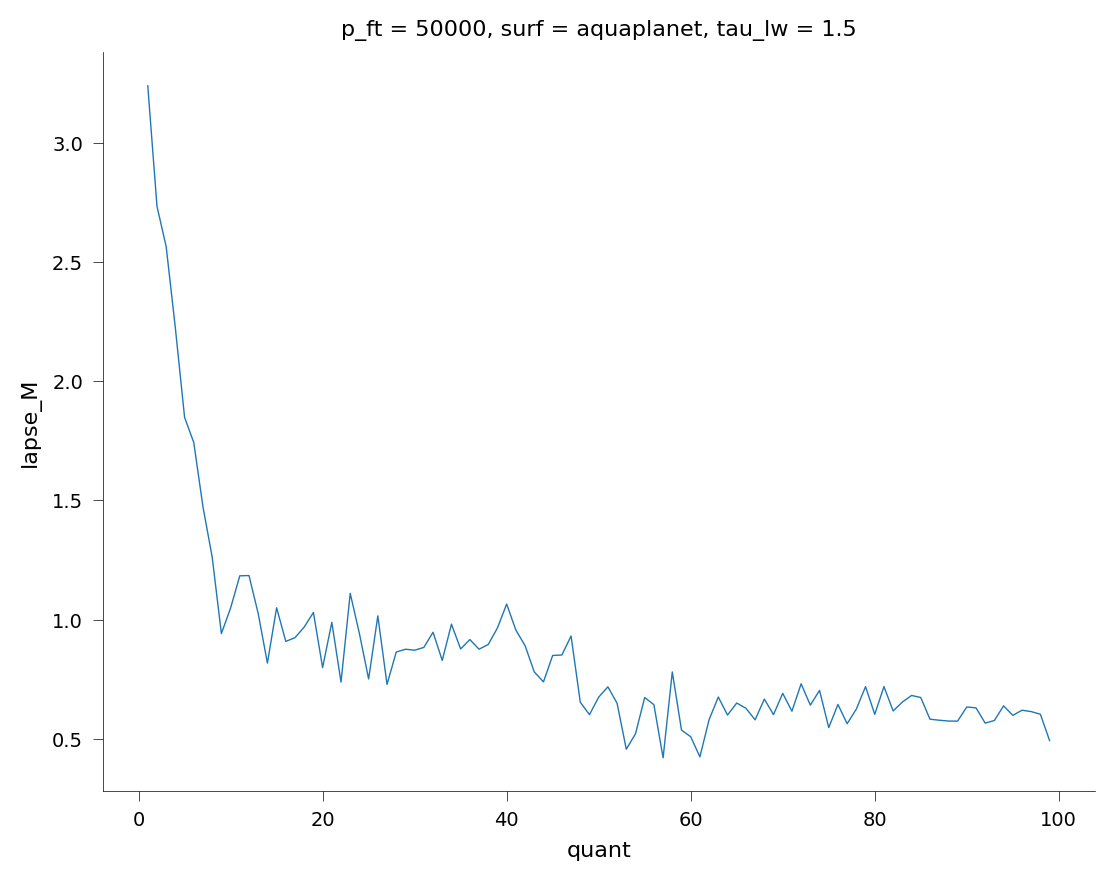

In [33]:
area_weighting(ds_use.lapse_M.mean(dim='sample')).mean(dim='lat').diff(dim='tau_lw').squeeze().plot()
# area_weighting(ds_use.lapse_M.mean(dim='sample')).mean(dim='lat').isel(tau_lw=1).plot()

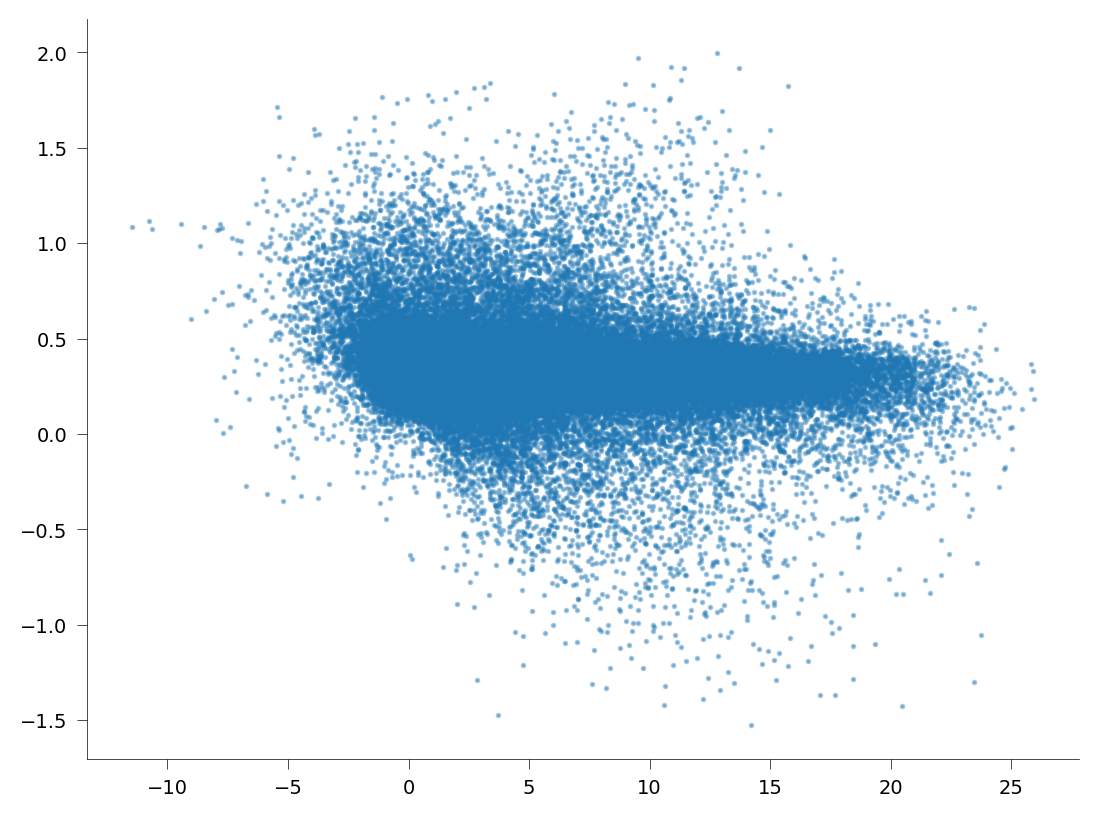

In [10]:
plt.scatter(ds_use.miy_M, ds_use.lapse_Mz*1000, s=1, alpha=0.4)

In [5]:
def get_ds_quant_and_ref(ds, error_thresh=0.25):
    # Take average over all days for which error satisfies convective threshold
    const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
    mod_parcel1_error = np.abs(ds.modParc1_error.sum(dim='layer') / ds.modParc1_integral.sum(dim='layer'))
    mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)# & (ds['p_lzb'] < p_ft)

    # Get rid of variables don't need anymore - those with lev and layer dimensions
    ds = ds.drop_dims(['lev', 'layer'])

    # ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
    # Reference is computed from all days
    ds_ref = ds.mean(dim=['sample', 'quant'])  # reference average over all convective days
    # For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
    ds_quant = ds.where(mask_fit).mean(dim='sample')

    # Add standard deviation for lapse rate variables
    ds_quant_std = ds[['lapse_D', 'lapse_M']].where(mask_fit).std(dim='sample')
    for key in ds_quant_std:
        ds_quant[f"{key}_std"] = ds_quant_std[key]
    return ds_quant, ds_ref, mask_fit
    # ds_ref = ds_quant.mean(dim='quant')  # reference, treat each quant the same so av TREFHT actuall


ds_quant, ds_ref, mask_use = get_ds_quant_and_ref(ds)

In [6]:
# Compute sCAPE from averaged quantities as takes too long to compute for each individual day
# Use parcel_def_include_z_approx=False because in this version of parcel definition, we get rid of A_z term
ds_quant['mse_REFHT'] = moist_static_energy(ds_quant.TREFHT, ds_quant.QREFHT, ds_quant.ZREFHT)
ds_quant['mse_ft_sat'] = moist_static_energy(ds_quant.T_ft_env, sphum_sat(ds_quant.T_ft_env, p_ft), ds_quant.Z_ft_env)
ds_quant['epsilon'] = ds_quant['mse_REFHT'] - ds_quant['mse_ft_sat']
get_cape_func = wrap_with_apply_ufunc(get_cape_approx, output_core_dims=[[], []])
ds_quant['sCAPE'] = get_cape_func(ds_quant.TREFHT, ds_quant.rh_REFHT, ds_quant.PREFHT, p_ft, ds_quant.T_ft_env,
                                  ds_quant.epsilon, parcel_def_include_z_approx=False)[0] * 1000

In [7]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(tau_lw=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(tau_lw=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_Mz'] = ds_ref['lapse_Mz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
ds_ref['lapse_M'] = ds_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
                                    p_ft, 0, 0, ds_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

ds_quant = ds_quant.transpose('tau_lw', 'quant', 'lat')
ds_ref = ds_ref.transpose('tau_lw', 'lat')

## Scaling factor
I first get the scaling factor both numerically and normal linear theory, making the function work with xarray.

In [9]:
def apply_scale_factor_numerical(ds_quant, ds_ref, p_ft=p_ft, lapse_coords='lnp', sCAPE_form=False):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_nl, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical2,
        ds_ref["TREFHT"],  # (tau_lw)
        ds_quant["TREFHT"],  # (tau_lw, quant)
        ds_ref["rh_REFHT"].isel(tau_lw=0),
        ds_quant["rh_REFHT"],  # (tau_lw, quant)
        ds_quant["T_ft_env"],  # (tau_lw, quant)
        p_ft,  # (tau_lw) or scalar
        ds_ref["PREFHT"].isel(tau_lw=0),  # scalar
        ds_quant["PREFHT"],  # (tau_lw, quant) or None
        ds_quant[f"lapse_D{'z' if lapse_coords == 'z' else ''}"] if not sCAPE_form else None,  # (tau_lw, quant)
        ds_quant[f"lapse_M{'z' if lapse_coords == 'z' else ''}"] if not sCAPE_form else None,  # (tau_lw, quant)
        ds_quant['sCAPE'] if sCAPE_form else None,
        kwargs=dict(
            temp_surf_lcl_calc=temp_surf_lcl_calc,
            lapse_coords=lapse_coords
        ),
        input_core_dims=[
            ["tau_lw"],  # temp_surf_ref
            ["tau_lw", "quant"],
            [],  # rh_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            [],  # p_ft_ref
            [],  # p_surf_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"] if not sCAPE_form else [],
            ["tau_lw", "quant"] if not sCAPE_form else [],
            ["tau_lw", "quant"] if sCAPE_form else []],
        output_core_dims=[
            ["quant"],  # result array
            ["quant"],
            ["quant"],
            []  # dict-of-arrays (broadcast to tau_lw)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, float, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds_quant['TREFHT'].isel(tau_lw=1) - ds_quant['TREFHT'].isel(tau_lw=0)
                                ) / (ds_ref['TREFHT'].isel(tau_lw=1) - ds_ref['TREFHT'].isel(tau_lw=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_dict.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_dict.sizes["lat"]):
            arr = out_dict.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "quant"),
            coords={"lat": ds_quant.lat, "quant": ds_quant.quant},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_nl": out_nl,
                         "scale_factor_linear": out_linear, **dict_ds})
    ds_out = ds_out.transpose("lat", "quant")
    return ds_out

In [10]:
def apply_scale_factor_theory(ds_quant, ds_ref, p_ft=p_ft, sCAPE_form=False):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset.
    Works in sCAPE or modParc form, depending on sCAPE_form parameter"""

    out_main, out_gamma, out_var, out_cont = xr.apply_ufunc(
        get_scale_factor_theory,
        ds_ref["TREFHT"],  # (tau_lw)
        ds_quant["TREFHT"],  # (tau_lw, quant)
        ds_ref["rh_REFHT"].isel(tau_lw=0),
        ds_quant["rh_REFHT"],  # (tau_lw, quant)
        ds_quant["T_ft_env"],  # (tau_lw, quant)
        p_ft,  # (tau_lw) or scalar
        ds_ref["PREFHT"].isel(tau_lw=0),  # scalar
        ds_quant["PREFHT"],  # (tau_lw, quant) or None
        ds_quant[f"lapse_D"] if not sCAPE_form else None,  # (tau_lw, quant)
        ds_quant[f"lapse_M"] if not sCAPE_form else None,  # (tau_lw, quant)
        ds_quant['sCAPE'] if sCAPE_form else None,  # (tau_lw, quant)
        kwargs=dict(
            temp_surf_lcl_calc=temp_surf_lcl_calc
        ),
        input_core_dims=[
            ["tau_lw"],  # temp_surf_ref
            ["tau_lw", "quant"],
            [],  # rh_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"],
            [],  # p_ft_ref
            [],  # p_surf_ref
            ["tau_lw", "quant"],
            ["tau_lw", "quant"] if not sCAPE_form else [],
            ["tau_lw", "quant"] if not sCAPE_form else [],
            ["tau_lw", "quant"] if sCAPE_form else []],
        output_core_dims=[
            ["quant"],  # result array
            [],  # dict-of-arrays (broadcast to tau_lw)
            [],  # dict-of-arrays (broadcast to tau_lw)
            []  # dict-of-arrays (broadcast to tau_lw)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, object, object, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds_quant['TREFHT'].isel(tau_lw=1) - ds_quant['TREFHT'].isel(tau_lw=0)
                                ) / (ds_ref['TREFHT'].isel(tau_lw=1) - ds_ref['TREFHT'].isel(tau_lw=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_cont.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_cont.sizes["lat"]):
            arr = out_cont.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "quant"),
            coords={"lat": ds_quant.lat, "quant": ds_quant.quant},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, **dict_ds})
    ds_out = ds_out.transpose("lat", "quant")
    return ds_out

In [11]:
%%time
ds_sf_num = apply_scale_factor_numerical(ds_quant, ds_ref, p_ft, 'lnp', sCAPE_form=False)
ds_sf_num_cape = apply_scale_factor_numerical(ds_quant, ds_ref, p_ft, 'lnp', sCAPE_form=True)
ds_sf = apply_scale_factor_theory(ds_quant, ds_ref, p_ft, sCAPE_form=False)
ds_sf_cape = apply_scale_factor_theory(ds_quant, ds_ref, p_ft, sCAPE_form=True)

In [12]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_num["nl_sum"] = ds_sf_num['scale_factor_nl'] - ds_sf_num['scale_factor_linear'] + 1
ds_sf_num_cape["nl_sum"] = ds_sf_num_cape['scale_factor_nl'] - ds_sf_num_cape['scale_factor_linear'] + 1

# Set numerical method to show difference to linear theory
for key in ds_sf:
    ds_sf_num[key] = ds_sf_num[key] - ds_sf[key] + 1
for key in ds_sf_cape:
    ds_sf_num_cape[key] = ds_sf_num_cape[key] - ds_sf_cape[key] + 1

### Theoretical scaling factor
Below I plot the theoretical scaling factor in modParc framework, also including sCAPE term as a comparison.

In [13]:
style_map = {
    # --- change (solid) ---
    "temp_ft_change": ("C2", "-", labels_cont['temp_ft_change']),
    "rh_change": ("C0", "-", labels_cont['rh_change']),
    "lapse_D_change": ("C8", "-", labels_cont['lapse_D_change']),
    "lapse_M_change": ("C1", "-", labels_cont['lapse_M_change']),
    "sCAPE_change": ("C1", ":", labels_cont['sCAPE_change']),

    # --- anomalies (dotted) ---
    "temp_surf_anom": ("C3", "-", labels_cont['temp_surf_anom']),

    # sf
    "scale_factor": ('k', "-", 'Simulated'),
    "scale_factor_sum": ('k', "--", 'Theory (modParc)'),

    # non-linear
    "nl_temp_surf_anom_rh_change": ('C3', '-', '$\Delta T_s \delta r_s$'),
    "nl_rh_change_lapse_D_anom": ('C0', '-', '$\Delta \eta_D \delta r_s$'),
    "nl_temp_surf_anom_lapse_M_change": ('C1', '-', '$\Delta T_s \delta \eta_M$'),
    "nl_temp_surf_anom_sCAPE_change": ('C1', ':', '$\Delta T_s \delta sCAPE$')
}

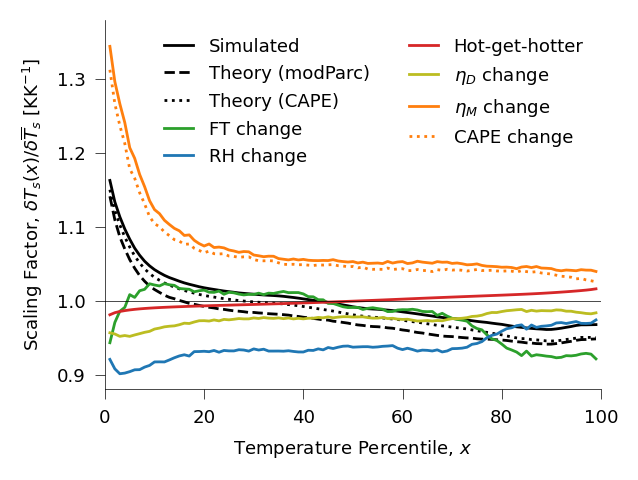

In [14]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False)
fig_resize(fig, width['one_col'])
for key in ['', '_sum']:
    ax.plot(ds_sf.quant, np.average(ds_sf[f"scale_factor{key}"], axis=0, weights=lat_weights),
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label=style_map[f"scale_factor{key}"][2])
ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[f"scale_factor_sum"], axis=0, weights=lat_weights),
        color=style_map[f"scale_factor_sum"][0],
        label='Theory (CAPE)', linestyle=':')
# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        continue
    if np.nanmax(np.average(np.abs(ds_sf[key] - 1), axis=0, weights=lat_weights)) < 0.012:
        continue
    # ax.plot(ds_sf_num.quant, np.average(var, axis=0, weights=lat_weights), label=key,
    #         color=style_map[key][0], linestyle=style_map[key][1])
    ax.plot(ds_sf.quant, np.average(ds_sf[key], axis=0, weights=lat_weights), label=style_map[key][2],
            color=style_map[key][0],
            linestyle=style_map[key][1])
    # # sanity check that all other mechanisms are the same
    # if 'lapse' in key:
    #     continue
    # ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape[key], axis=0, weights=lat_weights), color=style_map[key][0],
    #            linestyle=':')
ax.plot(ds_sf_cape.quant, np.average(ds_sf_cape['sCAPE_change'], axis=0, weights=lat_weights),
        color=style_map['sCAPE_change'][0], linestyle=':', label='CAPE change')

update_linewidth(fig)
ax.legend(ncol=2, handlelength=leg_handlelength)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig, 6.5)
ax.set_xlim(0, 100)
ax.set_ylim(0.88, 1.38)
# ax[0].legend(ncol=2)
plt.show()
# savefig(fig)

### Deviation from simulated and theoretical estimates
Why do the simulated and theoretical scaling factors differ?
Below, we split it up into neglecting terms in sum of individual mechanisms, and neglecting non-linear combination of mechanisms.

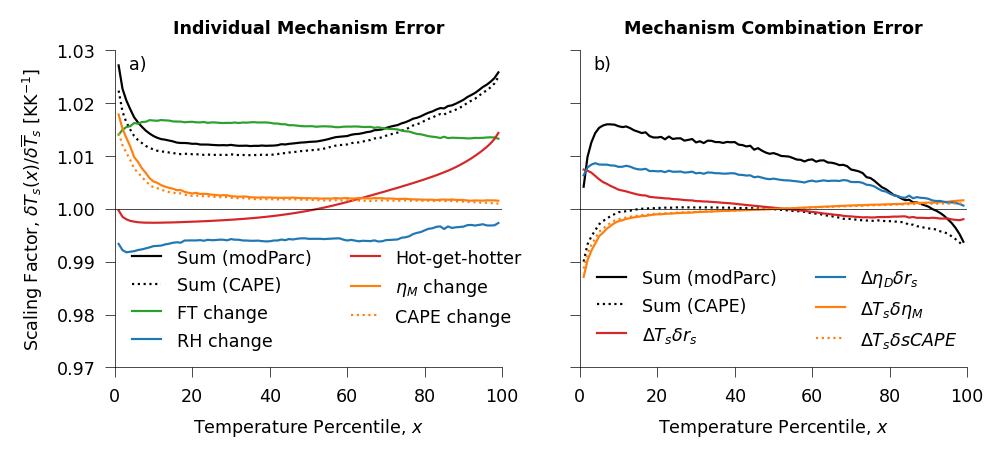

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# fig_resize(fig, 10)
ax[0].set_title('Individual Mechanism Error', fontweight='bold')
ax[1].set_title('Mechanism Combination Error', fontweight='bold')
ax[0].plot(ds_sf_num.quant,
           np.average(ds_sf_num['scale_factor_linear'] - ds_sf['scale_factor_sum'] + 1, axis=0, weights=lat_weights),
           color='k', label='Sum (modParc)')
ax[0].plot(ds_sf_num.quant,
           np.average(ds_sf_num_cape['scale_factor_linear'] - ds_sf_cape['scale_factor_sum'] + 1, axis=0,
                      weights=lat_weights),
           color='k', linestyle=':', label='Sum (CAPE)')

ax[1].plot(ds_sf_num_cape.quant, np.average(ds_sf_num['nl_sum'], axis=0, weights=lat_weights),
           color='k', linestyle='-', label='Sum (modParc)')
ax[1].plot(ds_sf_num_cape.quant, np.average(ds_sf_num_cape['nl_sum'], axis=0, weights=lat_weights),
           color='k', linestyle=':', label='Sum (CAPE)')

# Plot individual mechanism error
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    if np.nanmax(np.average(np.abs(ds_sf[key] - 1), axis=0, weights=lat_weights)) < 0.007:
        continue
    if np.nanmax(np.average(np.abs(ds_sf_num[key] - 1), axis=0, weights=lat_weights)) > 0.007:
        ax[0].plot(ds_sf.quant, np.average(ds_sf_num[key], axis=0, weights=lat_weights), label=style_map[key][2],
                   color=style_map[key][0],
                   linestyle=style_map[key][1])

# Plot combination of mechanism error
for key in ds_sf_num:
    if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key):
        continue
    if np.nanmax(np.average(np.abs(ds_sf_num[key] - 1), axis=0, weights=lat_weights)) > 0.007:
        ax[1].plot(ds_sf.quant, np.average(ds_sf_num[key], axis=0, weights=lat_weights), label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])

# Add the CAPE plots
key = 'sCAPE_change'
ax[0].plot(ds_sf_num_cape.quant, np.average(ds_sf_num_cape[key], axis=0, weights=lat_weights), label=style_map[key][2],
           color=style_map[key][0],
           linestyle=style_map[key][1])
key = 'nl_temp_surf_anom_sCAPE_change'
ax[1].plot(ds_sf_num_cape.quant,
           np.average(ds_sf_num_cape['nl_temp_surf_anom_sCAPE_change'], axis=0, weights=lat_weights),
           label=style_map[key][2], color=style_map[key][0], linestyle=style_map[key][1])

update_linewidth(fig)

# Reorder ax1 legend
handles, labels = ax[1].get_legend_handles_labels()
order = [0, 1, 2, 4, 3, 5]  # desired new order by index
ax[1].legend([handles[i] for i in order],
             [labels[i] for i in order], ncol=2, handlelength=leg_handlelength)

ax[0].legend(ncol=2, handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, pos_y=-2)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig)
ax[0].set_ylim(0.97, 1.03)
plt.show()
# savefig(fig)

## Lapse rate values
Show values of the lapse rate parameters, and also include daily max data for comparison, and to comment about dry lapse rate.

In [16]:
%%time
# Load in daily max as well for comparison later
ds_quant_daily_max = get_ds(['aquaplanet'], dailymax=True)['aquaplanet']

# Compute log pressure lapse rate quantities for each sample - then average over these
# Same for all variables, then have an averaging error at the end
# For each sample, modMSE_parc equation is satisfied, but this is not the case for the average day
ds_quant_daily_max['lapse_Dz'] = ds_quant_daily_max.modParc1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_quant_daily_max['lapse_Mz'] = ds_quant_daily_max.modParc1_lapse.isel(layer=1) / 1000
ds_quant_daily_max['lapse_D'] = R / g * ds_quant_daily_max.TREFHT * ds_quant_daily_max['lapse_Dz']
ds_quant_daily_max['lapse_M'] = R / g * ds_quant_daily_max.T_ft_env * ds_quant_daily_max['lapse_Mz']
# LZB function requires sample as a coordinate not dimension
if 'sample' not in ds_quant_daily_max.coords:
    ds_quant_daily_max = ds_quant_daily_max.assign_coords(sample=("sample", np.arange(ds_quant_daily_max.sizes["sample"])))

ds_quant_daily_max, ds_ref_daily_max, _ = get_ds_quant_and_ref(ds_quant_daily_max)

CPU times: user 12 s, sys: 1.36 s, total: 13.4 s
Wall time: 14.3 s


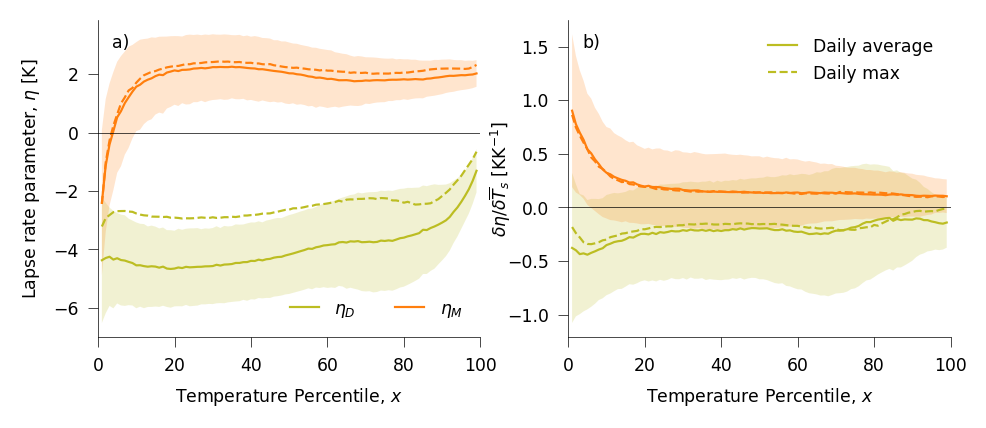

In [17]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False)
fig_resize(fig, width['two_col'])
for i, key in enumerate(['lapse_D', 'lapse_M']):
    ax[0].plot(ds_sf.quant, np.average(ds_quant[key].isel(tau_lw=0), axis=1, weights=lat_weights),
               color=style_map[f'{key}_change'][0], label=['$\eta_D$', '$\eta_M$'][i])
    ax[0].fill_between(ds_sf.quant,
                       np.average((ds_quant[key] - ds_quant[f"{key}_std"]).isel(tau_lw=0), axis=1, weights=lat_weights),
                       np.average((ds_quant[key] + ds_quant[f"{key}_std"]).isel(tau_lw=0), axis=1, weights=lat_weights),
                       alpha=0.2,
                       color=style_map[f'{key}_change'][0], edgecolor="none")
    var = ds_quant[key].diff(dim='tau_lw').squeeze() / ds_ref.TREFHT.diff(dim='tau_lw').squeeze()
    ax[1].plot(ds_sf.quant, np.average(var, axis=1, weights=lat_weights), color=style_map[f'{key}_change'][0],
               label='Daily average' if i == 0 else None)
    std_diff = np.sqrt(ds_quant[f"{key}_std"].isel(tau_lw=0) ** 2 + ds_quant[f"{key}_std"].isel(tau_lw=1) ** 2
                       ) / ds_ref.TREFHT.diff(dim='tau_lw').squeeze()
    ax[1].fill_between(ds_sf.quant,
                       np.average(var - std_diff, axis=1, weights=lat_weights),
                       np.average(var + std_diff, axis=1, weights=lat_weights),
                       alpha=0.2,
                       color=style_map[f'{key}_change'][0], edgecolor="none")

    ax[0].plot(ds_sf.quant, np.average(ds_quant_daily_max[key].isel(tau_lw=0), axis=1, weights=lat_weights),
               color=style_map[f'{key}_change'][0], linestyle='--')
    ax[1].plot(ds_sf.quant, np.average(
        ds_quant_daily_max[key].diff(dim='tau_lw').squeeze() / ds_ref_daily_max.TREFHT.diff(dim='tau_lw').squeeze(),
        axis=1, weights=lat_weights),
               color=style_map[f'{key}_change'][0], linestyle='--', label='Daily max' if i == 0 else None)
update_linewidth(fig)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend(handlelength=leg_handlelength, ncol=2, loc='lower right')
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, box_alpha=0)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel('Lapse rate parameter, $\eta$ [K]')
ax[1].set_ylabel('$\delta \eta/ \delta \overline{T}_s$ [KK$^{-1}$]', labelpad=-2)
fig.subplots_adjust(wspace=0.23)
update_fontsize(fig)
plt.show()
# savefig(fig)

In [6]:
def get_plzb_from_klzb(ds):
    # Returns lzb pressure in Pa from the kzlbs model index - requires interpolation to non integer index
    P = get_P(ds)
    k = ds.klzbs - 1        # Offset by -1 because fortran starts with 1, but python starts with 0

    # map fractional index k -> physical lev coordinate
    i = xr.DataArray(
        np.arange(ds.lev.size),
        dims=("lev",),
        coords={"lev": ds.lev},
    )

    lev_k = xr.apply_ufunc(
        np.interp,
        k,              # x: fractional index
        i,              # xp: integer indices 0..n_lev-1
        ds.lev,            # fp: lev values
        input_core_dims=[[], ['lev'], ['lev']],
        output_core_dims=[[]],
        vectorize=True,
    )

    # now do the "fractional isel" via interp along lev
    return P.interp(lev=lev_k)

# LZB function requires sample as a coordinate not dimension
if 'sample' not in ds.coords:
    ds = ds.assign_coords(sample=("sample", np.arange(ds.sizes["sample"])))
ds['p_lzb'] = get_plzb_from_klzb(ds)

In [8]:
ds_use = ds.sel(sample=slice(0, 4))

In [9]:
get_lnb_ind_xr = wrap_with_apply_ufunc(get_lnb_ind, input_core_dims=[['lev'], ['lev'], [], []])
ind = get_lnb_ind_xr(ds_use.T, get_P(ds_use), ds_use.rh_REFHT, ds_use.lapse_Dz,
                     temp_surf=None, p_surf=None, temp_surf_lcl_calc=temp_surf_lcl_calc)

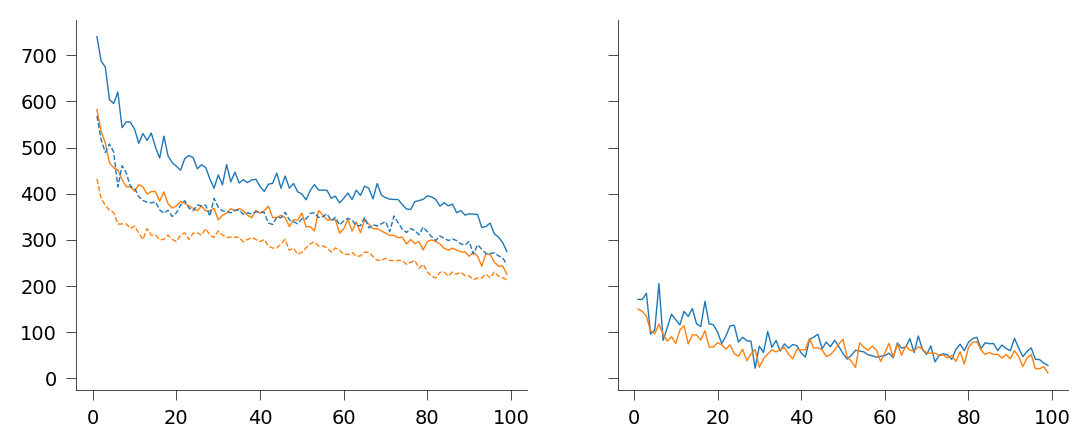

In [13]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig)
for j in range(2):
    ax[0].plot(ds.quant, np.average(ds_use.p_lzb.isel(tau_lw=j).quantile(0.5, dim='sample')/100, axis=1, weights=lat_weights), color=f"C0",
               linestyle=[None, '--'][j])
    ax[0].plot(ds_use.quant, np.average(ds_use.p_lzb_approx.isel(tau_lw=j).quantile(0.5, dim='sample')/100, axis=1, weights=lat_weights),
            color=f"C1",
               linestyle=[None, '--'][j])
    # ax[0].plot(ds_use.quant, np.average(ds_use.p_lzb_approx2.isel(tau_lw=j).quantile(0.5, dim='sample')/100, axis=1, weights=lat_weights),
    #         color=f"C2",
    #            linestyle=[None, '--'][j])
ax[1].plot(ds.quant, -np.average(ds_use.p_lzb.quantile(0.5, dim='sample').diff(dim='tau_lw').squeeze()/100, axis=1, weights=lat_weights), color=f"C0")
ax[1].plot(ds.quant, -np.average(ds_use.p_lzb_approx.quantile(0.5, dim='sample').diff(dim='tau_lw').squeeze()/100, axis=1, weights=lat_weights), color=f"C1")
# ax[1].plot(ds.quant, -np.average(ds_use.p_lzb_approx2.quantile(0.5, dim='sample').diff(dim='tau_lw').squeeze()/100, axis=1, weights=lat_weights), color=f"C2")